
# 화력발전 배연탈황 공정의 석회석 주입량 저감 최적화 모델

## 프로젝트 개요
이 프로젝트는 배연탈황 공정에서 **석회석 투입량을 최적화**하여 경제성을 높이고 환경 영향을 줄이는 것을 목표로 합니다.  
발전소의 유입 가스량, 배출 가스량, 탈황제 투입량 등의 데이터를 분석하여 최적화된 모델을 개발하였습니다.

## 주요 목표
- **석회석 투입량 최적화**: 불필요한 탈황제 사용을 줄이고 경제적 비용을 절감합니다.
- **데이터 기반 의사결정**: EDA 및 머신러닝 모델을 활용하여 최적의 석회석 투입 방식을 도출합니다.
- **환경 보호 기여**: 황산화물 배출량을 최소화하여 대기오염을 줄이는 역할을 합니다.


In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

import scipy.stats as stats

import dash
import dash_core_components as dc

import dash_html_components as html
import pandas as pd
import numpy as np
import sympy as sp

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from dash import dcc, html, Input, Output, Dash, State
from dash.dependencies import Output, Input
from numpy import trapz

C:\Users\dlwjd\AppData\Local\Temp\ipykernel_1008\4062431106.py:11: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dc
C:\Users\dlwjd\AppData\Local\Temp\ipykernel_1008\4062431106.py:13: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
df_komipo = pd.read_csv('./komi.csv', encoding = 'utf-8')
df_komipo.tail()

C:\Users\dlwjd\AppData\Local\Temp\ipykernel_1008\1325932127.py:1: DtypeWarning: Columns (1,2,4,5,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_komipo = pd.read_csv('./komi.csv', encoding = 'utf-8')


,date,power_3,outlet_3,normal_3,power_4,outlet_4,normal_4,power_5,outlet_5,normal_5,...,inlet_5,inlet_6,ph_3,ph_4,ph_5,ph_6,ton_3,ton_4,ton_5,ton_6
53275,2024-02-29 23:35,418,5.22,정상,0,6.82,정상,481,19.46,정상,...,335.489831,2.521914,6.04,4.83,5.18,6.98,20.185496,5.968,9.473010,0.0
53276,2024-02-29 23:40,418,4.99,정상,0,7.44,정상,482,20.21,정상,...,332.655682,2.531338,6.04,4.83,5.17,6.97,20.213262,5.902,9.271150,NaN
53277,2024-02-29 23:45,418,4.86,정상,0,6.83,정상,476,20.24,정상,...,331.522790,2.450782,6.04,4.83,5.18,6.97,20.188637,5.906,9.112337,0.0
53278,2024-02-29 23:50,419,4.8,정상,0,7.09,정상,473,20.25,정상,...,313.757489,2.571517,6.04,4.83,5.18,6.97,20.196018,5.936,9.011972,NaN
53279,2024-02-29 23:55,420,5.01,정상,0,6.86,정상,470,18.76,정상,...,165.986595,2.433664,6.04,4.83,5.18,6.97,20.196117,5.920,8.833662,0.0


### dashboard를 통하여 확인하여 발전량과 연관이 있는 데이터만 추출

In [3]:
df_3 = df_komipo[['date','power_3','outlet_3','inlet_3','ton_3','normal_3']]
df_3 = df_3.reset_index(drop=True)

df_4 = df_komipo[['date','power_4','outlet_4','inlet_4','ton_4','normal_4']]
df_4 = df_4.reset_index(drop=True)

df_5 = df_komipo[['date','power_5','outlet_5','inlet_5','ton_5','normal_5']]
df_5 = df_5.reset_index(drop=True)

df_6 = df_komipo[['date','power_6','outlet_6','inlet_6','ton_6','normal_6']]
df_6 = df_6.reset_index(drop=True)

### 각 데이터의 10분 후의 값들이 발전량과 연관이 있는 모습을 띄었으므로 10분 뒤의 값들을 이용

In [4]:
df3_10min = df_3.loc[2:].reset_index(drop=True)
df3_10min.columns = ['date_10min','power_10min','outlet_10min','inlet_10min','ton_10min','normal_10min']

df4_10min = df_4.loc[2:].reset_index(drop=True)
df4_10min.columns = ['date_10min','power_10min','outlet_10min','inlet_10min','ton_10min','normal_10min']

df5_10min = df_5.loc[2:].reset_index(drop=True)
df5_10min.columns = ['date_10min','power_10min','outlet_10min','inlet_10min','ton_10min','normal_10min']

df6_10min = df_6.loc[2:].reset_index(drop=True)
df6_10min.columns = ['date_10min','power_10min','outlet_10min','inlet_10min','ton_10min','normal_10min']

In [5]:
df_3 = pd.concat([df_3, df3_10min], axis=1)
df_4 = pd.concat([df_4, df4_10min], axis=1)
df_5 = pd.concat([df_5, df5_10min], axis=1)
df_6 = pd.concat([df_6, df6_10min], axis=1)

In [6]:
df_3.dropna(inplace = True)
df_4.dropna(inplace = True)
df_5.dropna(inplace = True)
df_6.dropna(inplace = True)

df_3 = df_3[~df_3.astype('str').apply(lambda row:'-' in row.values, axis = 1)]
df_4 = df_4[~df_4.astype('str').apply(lambda row:'-' in row.values, axis = 1)]
df_5 = df_5[~df_5.astype('str').apply(lambda row:'-' in row.values, axis = 1)]
df_6 = df_6[~df_6.astype('str').apply(lambda row:'-' in row.values, axis = 1)]

In [7]:
list3 = ['power_3','inlet_3','outlet_3','power_10min','outlet_10min','inlet_10min','ton_10min']
list4 = ['power_4','inlet_4','outlet_4','power_10min','outlet_10min','inlet_10min','ton_10min']
list5 = ['power_5','inlet_5','outlet_5','power_10min','outlet_10min','inlet_10min','ton_10min']
list6 = ['power_6','inlet_6','outlet_6','power_10min','outlet_10min','inlet_10min','ton_10min']

for i in list3:
    df_3[i] = df_3[i].astype('str')
for i in list4:
    df_4[i] = df_4[i].astype('str')
for i in list5: 
    df_5[i] = df_5[i].astype('str')
for i in list6: 
    df_6[i] = df_6[i].astype('str')

for i in list3:
    df_3[i] = df_3[i].str.replace(',','').astype(float)
for i in list4:
    df_4[i] = df_4[i].str.replace(',','').astype(float)
for i in list5:
    df_5[i] = df_5[i].str.replace(',','').astype(float)
for i in list6:
    df_6[i] = df_6[i].str.replace(',','').astype(float)

df_3['date'] = df_3['date'].astype('datetime64[ns]')
df_4['date'] = df_4['date'].astype('datetime64[ns]')
df_5['date'] = df_5['date'].astype('datetime64[ns]')
df_6['date'] = df_6['date'].astype('datetime64[ns]')

In [8]:
df_3 = df_3[df_3['normal_3'] == '정상']
df_3 = df_3[df_3['inlet_3'] >= 0]
df_3 = df_3[df_3['ton_3'] >= 0]

df_5 = df_5[df_5['normal_5'] == '정상']
df_5 = df_5[df_5['inlet_5'] >= 0]
df_5 = df_5[df_5['ton_5'] >= 0]

df_6 = df_6[df_6['normal_6'] == '정상']
df_6 = df_6[df_6['inlet_6'] >= 0]
df_6 = df_6[df_6['ton_6'] >= 0]

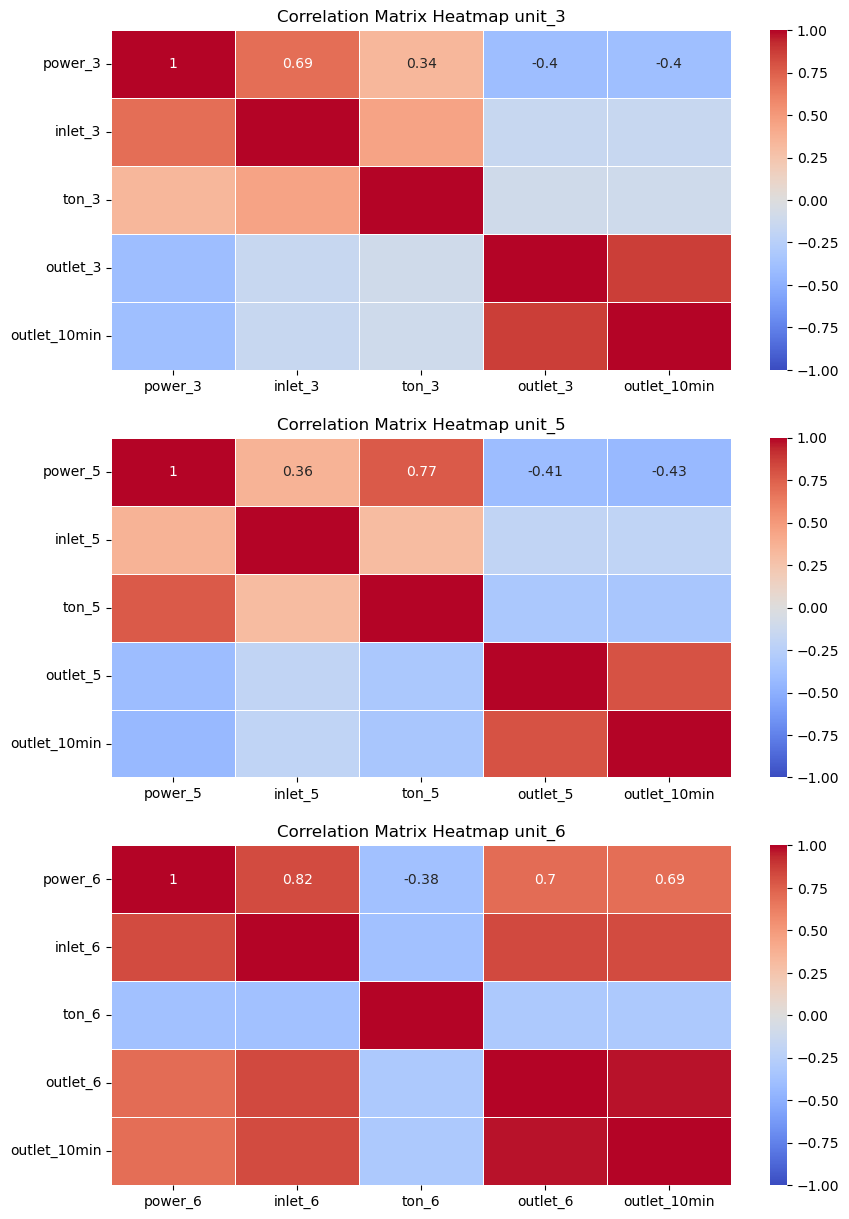

In [9]:
df_31 = df_3[['date','power_3','inlet_3','ton_3','normal_3','outlet_3','outlet_10min']]
df_51 = df_5[['date','power_5','inlet_5','ton_5','normal_5','outlet_5','outlet_10min']]
df_61 = df_6[['date','power_6','inlet_6','ton_6','normal_6','outlet_6','outlet_10min']]

corr3 = df_31[['power_3','inlet_3','ton_3','outlet_3','outlet_10min']].corr()
corr5 = df_51[['power_5','inlet_5','ton_5','outlet_5','outlet_10min']].corr()
corr6 = df_61[['power_6','inlet_6','ton_6','outlet_6','outlet_10min']].corr()
plt.figure(figsize=(10, 15.))

plt.subplot(311)
sns.heatmap(corr3, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap unit_3')

plt.subplot(312)
sns.heatmap(corr5, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap unit_5')

plt.subplot(313)
sns.heatmap(corr6, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap unit_6')
plt.show()

In [10]:
df_3 = df_3[df_3['normal_3'] == '정상']
df_3 = df_3[df_3['inlet_3'] >= 0]
df_3 = df_3[df_3['ton_3'] >= 0]
df_3 = df_3[df_3['power_3'] >= 300]

df_4 = df_4[df_4['normal_4'] == '정상']
df_4 = df_4[df_4['inlet_4'] >= 0]
df_4 = df_4[df_4['ton_4'] >= 0]

df_5 = df_5[df_5['normal_5'] == '정상']
df_5 = df_5[df_5['inlet_5'] >= 0]
df_5 = df_5[df_5['ton_5'] >= 0]
df_5 = df_5[df_5['power_5'] >= 300]

df_6 = df_6[df_6['normal_6'] == '정상']
df_6 = df_6[df_6['inlet_6'] >= 0]
df_6 = df_6[df_6['ton_6'] >= 0]
df_6 = df_6[df_6['power_6'] >= 300]

(array([2.8400e+02, 9.9000e+01, 2.7900e+02, 5.4600e+02, 3.3400e+02,
        1.5400e+02, 7.1700e+02, 1.5800e+02, 8.7000e+01, 7.4000e+01,
        2.3320e+03, 1.0690e+03, 6.1000e+02, 8.1110e+03, 1.9933e+04,
        1.0900e+02, 2.8600e+02, 3.0000e+00, 0.0000e+00, 1.7000e+01]),
 array([300.  , 312.35, 324.7 , 337.05, 349.4 , 361.75, 374.1 , 386.45,
        398.8 , 411.15, 423.5 , 435.85, 448.2 , 460.55, 472.9 , 485.25,
        497.6 , 509.95, 522.3 , 534.65, 547.  ]),
 <BarContainer object of 20 artists>)

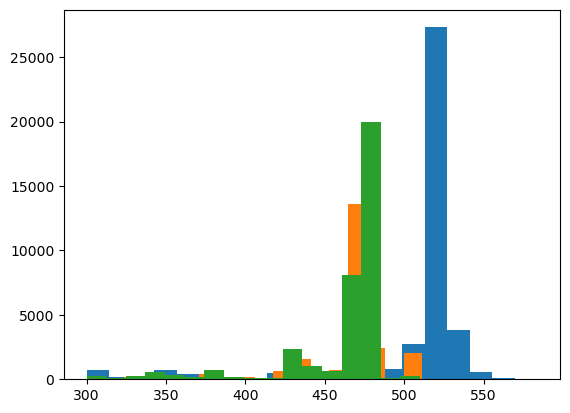

In [11]:
plt.hist(df_3.power_3,bins = 20)
plt.hist(df_5.power_5,bins = 20)
plt.hist(df_6.power_6,bins = 20)

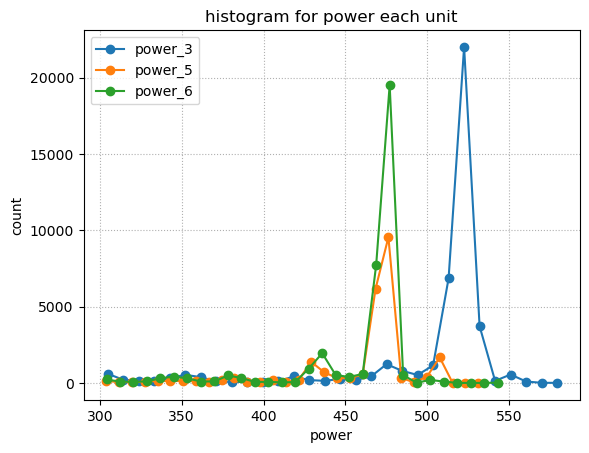

In [12]:
#hist3 = pd.Series(df_3.power_3).plot(kind='hist', bins=30, alpha= 0)
#hist5 = pd.Series(df_5.power_5).plot(kind='hist', bins=30, alpha= 0)
#hist6 = pd.Series(df_6.power_6).plot(kind='hist', bins=30, alpha= 0)

# hist 데이터로부터 막대 높이와 경계값 가져오기
counts3, bin_edges3 = np.histogram(df_3.power_3, bins=30)
counts5, bin_edges5 = np.histogram(df_5.power_5, bins=30)
counts6, bin_edges6 = np.histogram(df_6.power_6, bins=30)

# 막대의 중앙값 계산
bin_centers3 = 0.5 * (bin_edges3[:-1] + bin_edges3[1:])
bin_centers5 = 0.5 * (bin_edges5[:-1] + bin_edges5[1:])
bin_centers6 = 0.5 * (bin_edges6[:-1] + bin_edges6[1:])

# 히스토그램을 선으로 플롯
plt.plot(bin_centers3, counts3, linestyle='-', marker='o', label = 'power_3')
plt.plot(bin_centers5, counts5, linestyle='-', marker='o', label = 'power_5')
plt.plot(bin_centers6, counts6, linestyle='-', marker='o', label = 'power_6')

plt.xlabel('power')
plt.ylabel('count')
plt.legend()
plt.grid(linestyle=':')
plt.title('histogram for power each unit')

# 그래프 표시
plt.show()

In [13]:
df_31 = df_3[['date','power_3','inlet_3','ton_3','normal_3','outlet_3','outlet_10min']]
display(df_31.head())
df_51 = df_5[['date','power_5','inlet_5','ton_5','normal_5','outlet_5','outlet_10min']]
display(df_51.head())
df_61 = df_6[['date','power_6','inlet_6','ton_6','normal_6','outlet_6','outlet_10min']]
display(df_61.head())

,date,power_3,inlet_3,ton_3,normal_3,outlet_3,outlet_10min
0,2023-09-01 00:00:00,474.0,189.45,5.71,정상,0.68,0.40
1,2023-09-01 00:05:00,486.0,188.30,3.07,정상,0.36,1.74
2,2023-09-01 00:10:00,510.0,186.30,3.43,정상,0.40,1.52
3,2023-09-01 00:15:00,518.0,188.13,10.62,정상,1.74,0.82
4,2023-09-01 00:20:00,518.0,191.39,11.99,정상,1.52,0.83


,date,power_5,inlet_5,ton_5,normal_5,outlet_5,outlet_10min
1,2023-09-01 00:05:00,473.0,185.77,0.03,정상,15.52,16.69
3,2023-09-01 00:15:00,454.0,185.77,0.03,정상,16.69,16.33
5,2023-09-01 00:25:00,430.0,129.13,0.03,정상,16.33,16.28
6,2023-09-01 00:30:00,428.0,98.60,0.03,정상,16.84,16.06
7,2023-09-01 00:35:00,429.0,128.22,0.03,정상,16.28,15.85


,date,power_6,inlet_6,ton_6,normal_6,outlet_6,outlet_10min
0,2023-09-01 00:00:00,443.0,240.87,5.56,정상,13.37,14.17
1,2023-09-01 00:05:00,474.0,244.57,5.76,정상,13.16,13.73
2,2023-09-01 00:10:00,483.0,228.00,6.95,정상,14.17,14.50
3,2023-09-01 00:15:00,475.0,233.27,8.05,정상,13.73,14.14
4,2023-09-01 00:20:00,475.0,243.46,17.81,정상,14.50,14.98


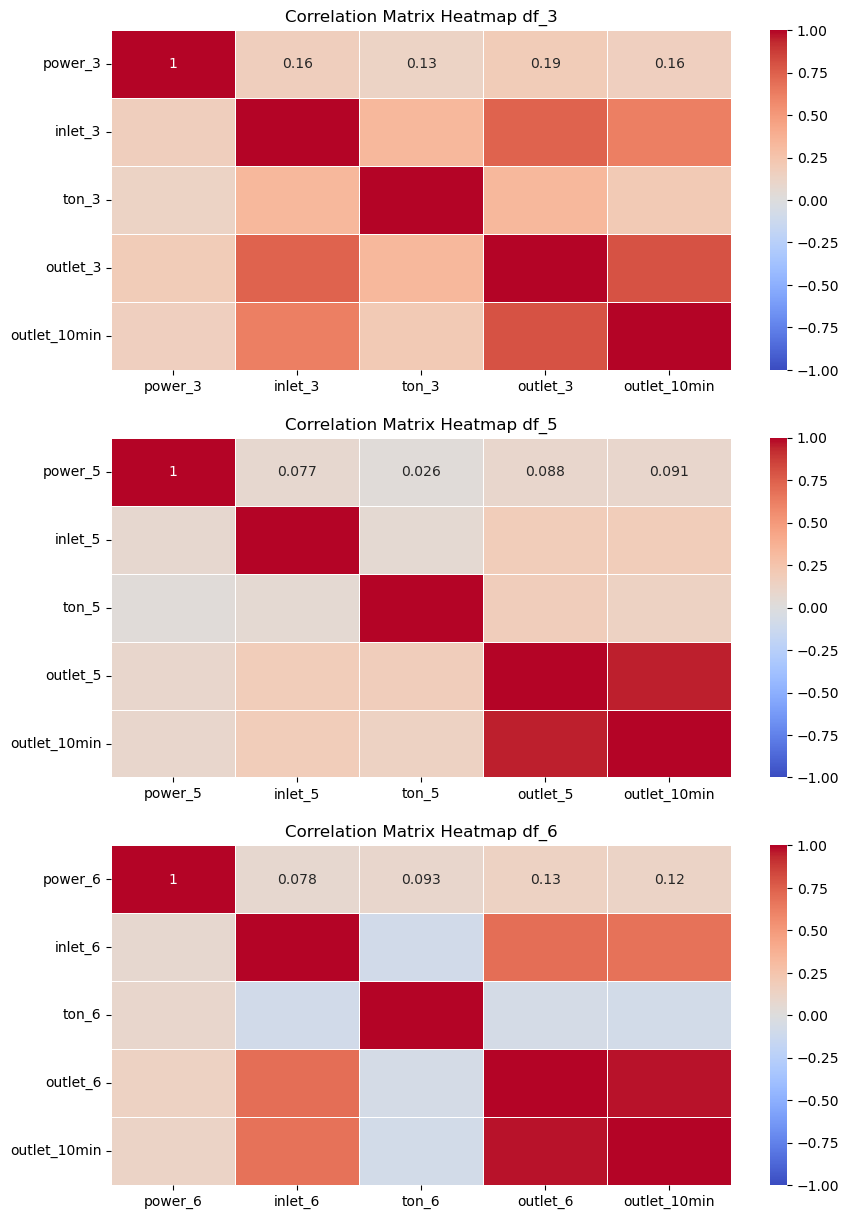

In [14]:
corr3 = df_31[['power_3','inlet_3','ton_3','outlet_3','outlet_10min']].corr()
corr5 = df_51[['power_5','inlet_5','ton_5','outlet_5','outlet_10min']].corr()
corr6 = df_61[['power_6','inlet_6','ton_6','outlet_6','outlet_10min']].corr()
plt.figure(figsize=(10, 15.))

plt.subplot(311)
sns.heatmap(corr3, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap df_3')

plt.subplot(312)
sns.heatmap(corr5, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap df_5')

plt.subplot(313)
sns.heatmap(corr6, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap df_6')
plt.show()

In [15]:
bins10 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=10)
df_3['power_bins10'] = pd.cut(df_3['power_3'], bins=bins10)

bins14 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=14)
df_3['power_bins14'] = pd.cut(df_3['power_3'], bins=bins14)

bins20 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=20)
df_3['power_bins20'] = pd.cut(df_3['power_3'], bins=bins20)

bins25 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=25)
df_3['power_bins25'] = pd.cut(df_3['power_3'], bins=bins25)

bins30 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=30)
df_3['power_bins30'] = pd.cut(df_3['power_3'], bins=bins30)

bins50 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=50)
df_3['power_bins50'] = pd.cut(df_3['power_3'], bins=bins50)

bins70 = pd.interval_range(start=df_3.power_3.min()-1, end=df_3.power_3.max()+1, periods=70)
df_3['power_bins70'] = pd.cut(df_3['power_3'], bins=bins70)

In [16]:
lst3_10 = []

for i in range(10):
    globals()[f'df3_10_{i}'] = df_3[df_3['power_bins10'] == bins10[i]]
    lst3_10.append(globals()[f'df3_10_{i}'])

lst3_14 = []

for i in range(14):
    globals()[f'df3_14_{i}'] = df_3[df_3['power_bins14'] == bins14[i]]
    lst3_14.append(globals()[f'df3_14_{i}'])

lst3_20 = []

for i in range(20):
    globals()[f'df3_20_{i}'] = df_3[df_3['power_bins20'] == bins20[i]]
    lst3_20.append(globals()[f'df3_20_{i}'])

lst3_25 = []

for i in range(25):
    globals()[f'df3_25_{i}'] = df_3[df_3['power_bins25'] == bins25[i]]
    lst3_25.append(globals()[f'df3_25_{i}'])

lst3_30 = []

for i in range(30):
    globals()[f'df3_30_{i}'] = df_3[df_3['power_bins30'] == bins30[i]]
    lst3_30.append(globals()[f'df3_30_{i}'])

lst3_50 = []

for i in range(50):
    globals()[f'df3_50_{i}'] = df_3[df_3['power_bins50'] == bins50[i]]
    lst3_50.append(globals()[f'df3_50_{i}'])

lst3_70 = []

for i in range(70):
    globals()[f'df3_70_{i}'] = df_3[df_3['power_bins70'] == bins70[i]]
    lst3_70.append(globals()[f'df3_70_{i}'])

In [17]:
bins10 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=10)
df_5['power_bins10'] = pd.cut(df_5['power_5'], bins=bins10)

bins14 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=14)
df_5['power_bins14'] = pd.cut(df_5['power_5'], bins=bins14)

bins20 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=20)
df_5['power_bins20'] = pd.cut(df_5['power_5'], bins=bins20)

bins25 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=25)
df_5['power_bins25'] = pd.cut(df_5['power_5'], bins=bins25)

bins30 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=30)
df_5['power_bins30'] = pd.cut(df_5['power_5'], bins=bins30)

bins35 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=35)
df_5['power_bins35'] = pd.cut(df_5['power_5'], bins=bins35)

bins50 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=50)
df_5['power_bins50'] = pd.cut(df_5['power_5'], bins=bins50)

bins70 = pd.interval_range(start=df_5.power_5.min()-1, end=df_5.power_5.max()+1, periods=70)
df_5['power_bins70'] = pd.cut(df_5['power_5'], bins=bins70)

In [18]:
lst5_10 = []

for i in range(10):
    globals()[f'df5_10_{i}'] = df_5[df_5['power_bins10'] == bins10[i]]
    lst5_10.append(globals()[f'df5_10_{i}'])

lst5_14 = []

for i in range(14):
    globals()[f'df5_14_{i}'] = df_5[df_5['power_bins14'] == bins14[i]]
    lst5_14.append(globals()[f'df5_14_{i}'])

lst5_20 = []

for i in range(20):
    globals()[f'df5_20_{i}'] = df_5[df_5['power_bins20'] == bins20[i]]
    lst5_20.append(globals()[f'df5_20_{i}'])

lst5_25 = []

for i in range(25):
    globals()[f'df5_25_{i}'] = df_5[df_5['power_bins25'] == bins25[i]]
    lst5_25.append(globals()[f'df5_25_{i}'])

lst5_30 = []

for i in range(30):
    globals()[f'df5_30_{i}'] = df_5[df_5['power_bins30'] == bins30[i]]
    lst5_30.append(globals()[f'df5_30_{i}'])

lst5_35 = []

for i in range(35):
    globals()[f'df5_35_{i}'] = df_5[df_5['power_bins35'] == bins35[i]]
    lst5_35.append(globals()[f'df5_35_{i}'])

lst5_50 = []

for i in range(50):
    globals()[f'df5_50_{i}'] = df_5[df_5['power_bins50'] == bins50[i]]
    lst5_50.append(globals()[f'df5_50_{i}'])

lst5_70 = []

for i in range(70):
    globals()[f'df5_70_{i}'] = df_5[df_5['power_bins70'] == bins70[i]]
    lst5_70.append(globals()[f'df5_70_{i}'])

In [20]:
bins10 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=10)
df_6['power_bins10'] = pd.cut(df_6['power_6'], bins=bins10)

bins14 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=14)
df_6['power_bins14'] = pd.cut(df_6['power_6'], bins=bins14)

bins20 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=20)
df_6['power_bins20'] = pd.cut(df_6['power_6'], bins=bins20)

bins25 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=25)
df_6['power_bins25'] = pd.cut(df_6['power_6'], bins=bins25)

bins30 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=30)
df_6['power_bins30'] = pd.cut(df_6['power_6'], bins=bins30)

bins50 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=50)
df_6['power_bins50'] = pd.cut(df_6['power_6'], bins=bins50)

bins70 = pd.interval_range(start=df_6.power_6.min()-1, end=df_6.power_6.max()+1, periods=70)
df_6['power_bins70'] = pd.cut(df_6['power_6'], bins=bins70)

In [25]:
lst6_10 = []

for i in range(10):
    globals()[f'df6_10_{i}'] = df_6[df_6['power_bins10'] == bins10[i]]
    lst6_10.append(globals()[f'df6_10_{i}'])

lst6_14 = []

for i in range(14):
    globals()[f'df6_14_{i}'] = df_6[df_6['power_bins14'] == bins14[i]]
    lst6_14.append(globals()[f'df6_14_{i}'])

lst6_20 = []

for i in range(20):
    globals()[f'df6_20_{i}'] = df_6[df_6['power_bins20'] == bins20[i]]
    lst6_20.append(globals()[f'df6_20_{i}'])

lst6_25 = []

for i in range(25):
    globals()[f'df6_25_{i}'] = df_6[df_6['power_bins25'] == bins25[i]]
    lst6_25.append(globals()[f'df6_25_{i}'])

lst6_30 = []

for i in range(30):
    globals()[f'df6_30_{i}'] = df_6[df_6['power_bins30'] == bins30[i]]
    lst6_30.append(globals()[f'df6_30_{i}'])

lst6_50 = []

for i in range(50):
    globals()[f'df6_50_{i}'] = df_6[df_6['power_bins50'] == bins50[i]]
    lst6_50.append(globals()[f'df6_50_{i}'])

lst6_70 = []

for i in range(70):
    globals()[f'df6_70_{i}'] = df_6[df_6['power_bins70'] == bins70[i]]
    lst6_70.append(globals()[f'df6_70_{i}'])

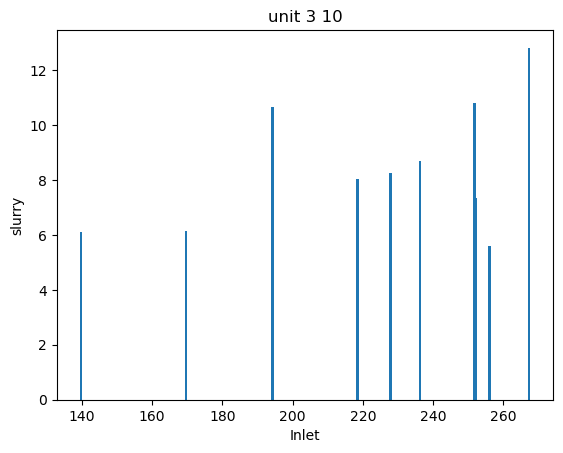

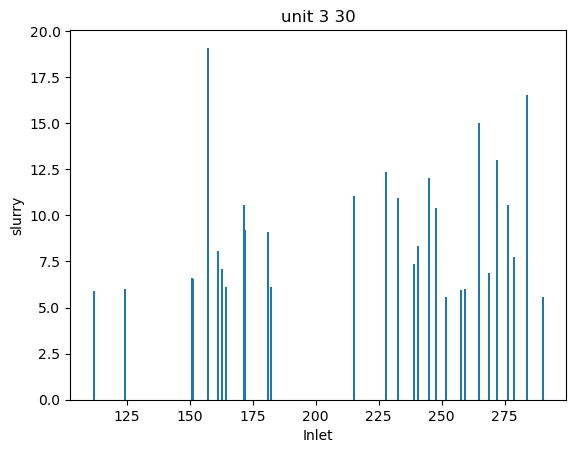

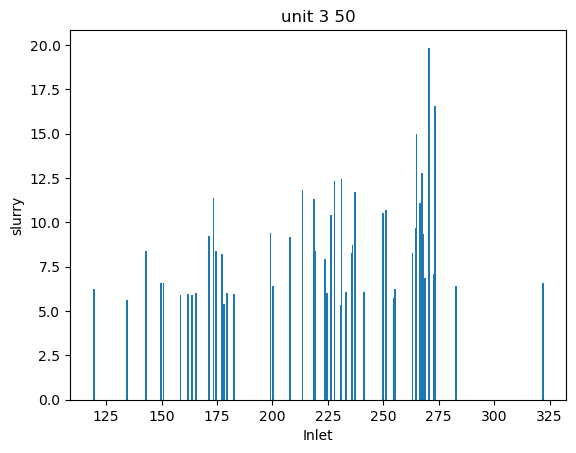

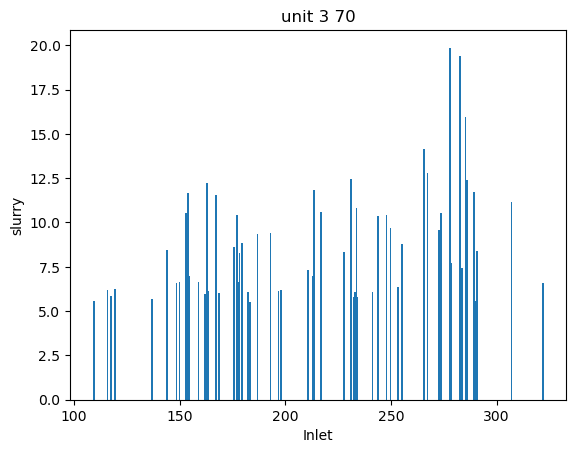

In [26]:
quantile3_10 = pd.DataFrame(columns=df3_10_1.columns)

for index, value in enumerate(lst3_10):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile3_10.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile3_10['inlet_3'], quantile3_10['ton_10min'], label='10')
plt.title('unit 3 10')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
########################################################################
quantile3_30 = pd.DataFrame(columns=df3_30_1.columns)

for index, value in enumerate(lst3_30):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile3_30.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile3_30['inlet_3'], quantile3_30['ton_10min'], label='30')
plt.title('unit 3 30')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile3_50 = pd.DataFrame(columns=df3_50_1.columns)

for index, value in enumerate(lst3_50):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile3_50.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile3_50['inlet_3'], quantile3_50['ton_10min'], label='50')
plt.title('unit 3 50')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile3_70 = pd.DataFrame(columns=df3_70_1.columns)

for index, value in enumerate(lst3_70):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile3_70.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile3_70['inlet_3'], quantile3_70['ton_10min'], label='50')
plt.title('unit 3 70')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()

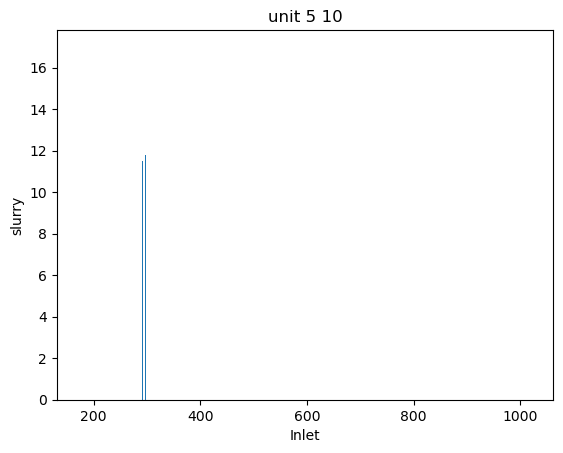

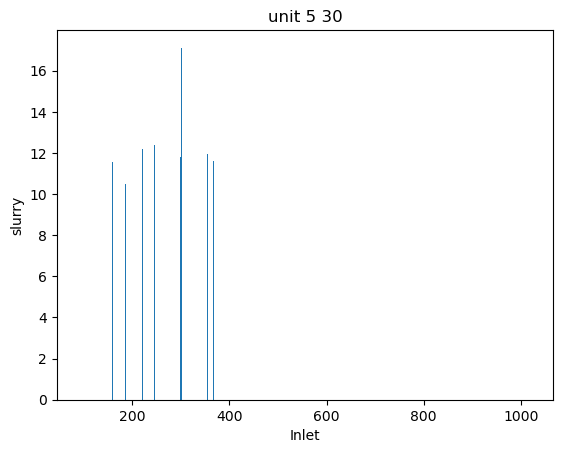

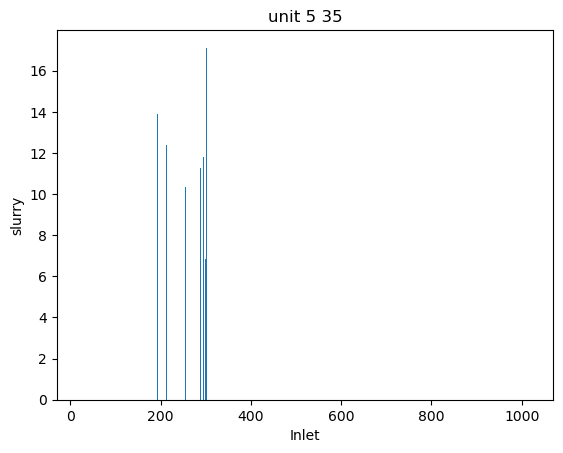

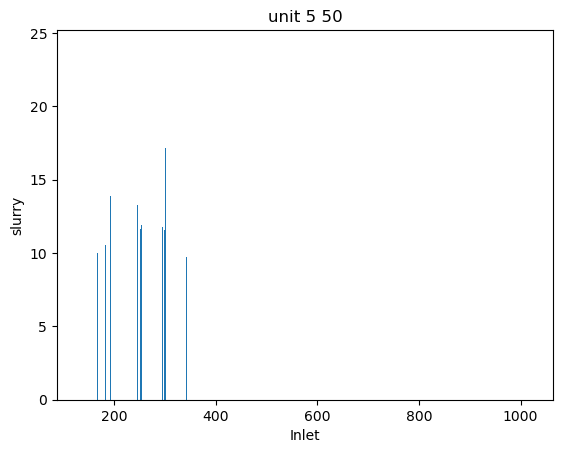

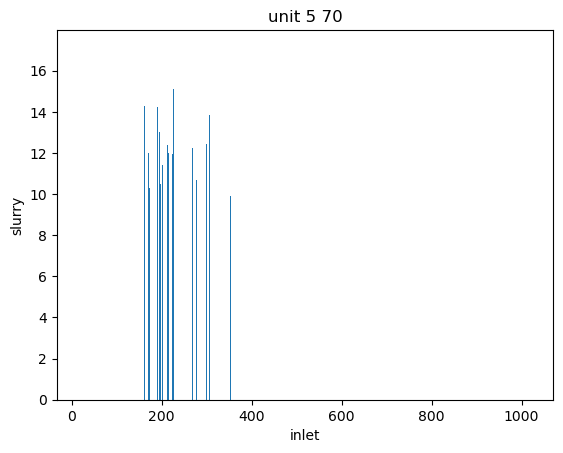

In [27]:
quantile5_10 = pd.DataFrame(columns=df5_10_1.columns)

for index, value in enumerate(lst5_10):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile5_10.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile5_10['inlet_5'], quantile5_10['ton_10min'], label='10')
plt.title('unit 5 10')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
########################################################################
quantile5_30 = pd.DataFrame(columns=df5_30_1.columns)

for index, value in enumerate(lst5_30):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile5_30.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile5_30['inlet_5'], quantile5_30['ton_10min'], label='30')
plt.title('unit 5 30')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile5_35 = pd.DataFrame(columns=df5_35_1.columns)

for index, value in enumerate(lst5_35):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile5_35.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile5_35['inlet_5'], quantile5_35['ton_10min'], label='30')
plt.title('unit 5 35')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile5_50 = pd.DataFrame(columns=df5_50_1.columns)

for index, value in enumerate(lst5_50):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile5_50.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile5_50['inlet_5'], quantile5_50['ton_10min'], label='50')
plt.title('unit 5 50')
plt.xlabel('Inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile5_70 = pd.DataFrame(columns=df5_70_1.columns)

for index, value in enumerate(lst5_70):
    if len(value) == 0:
        quantile5_70.loc[index] = pd.Series(dtype='float64')
    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile5_70.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile5_70['inlet_5'], quantile5_70['ton_10min'], label='50')
plt.title('unit 5 70')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()

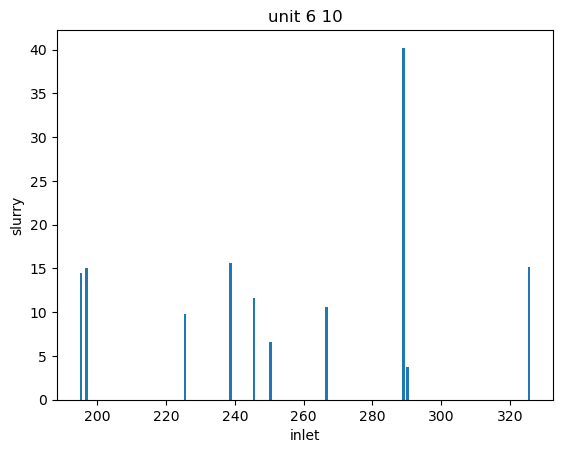

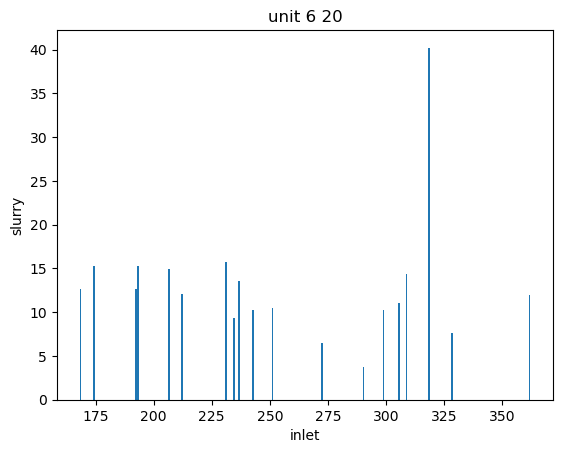

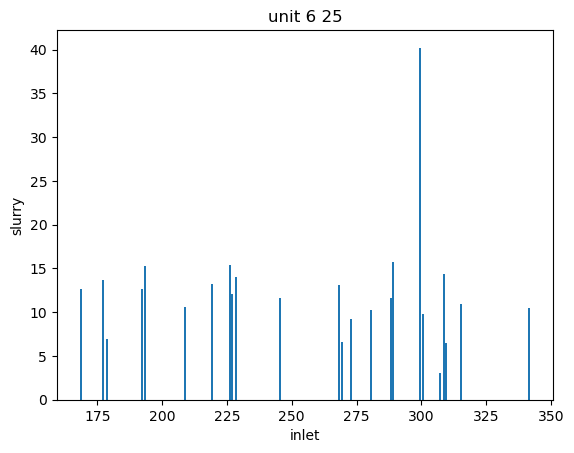

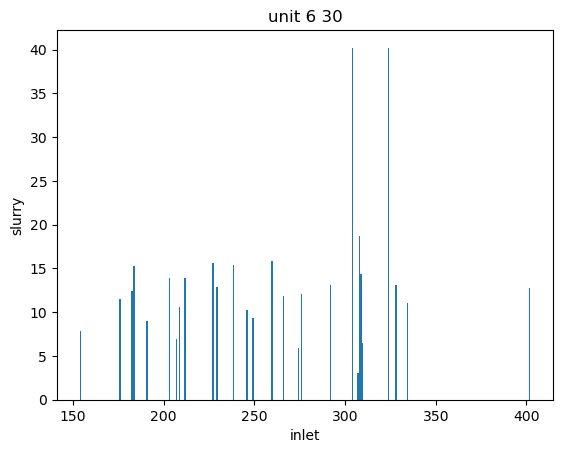

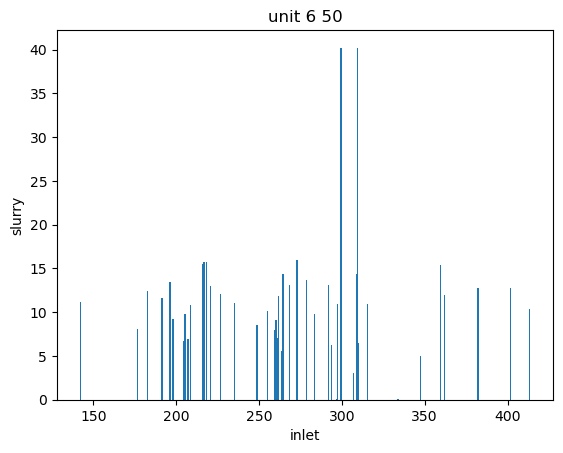

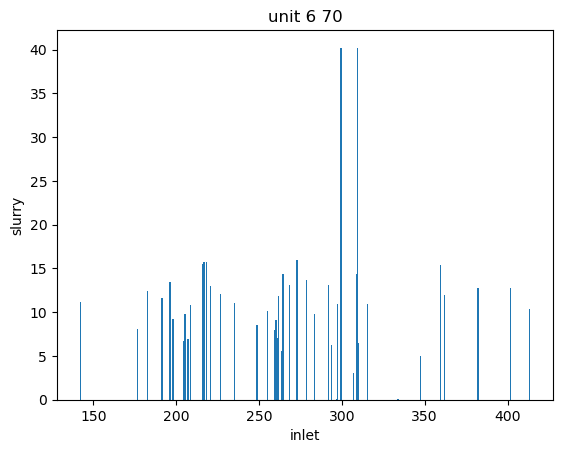

In [28]:
quantile6_10 = pd.DataFrame(columns=df6_10_1.columns)

for index, value in enumerate(lst6_10):
    q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
    quantile6_10.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile6_10['inlet_6'], quantile6_10['ton_10min'], label='10')
plt.title('unit 6 10')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()
########################################################################
quantile6_20 = pd.DataFrame(columns=df6_20_1.columns)

for index, value in enumerate(lst6_20):
    if len(value) == 0:
        quantile6_20.loc[index] = pd.Series(dtype='float64')

    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile6_20.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile6_20['inlet_6'], quantile6_20['ton_10min'], label='10')
plt.title('unit 6 20')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile6_25 = pd.DataFrame(columns=df6_25_1.columns)

for index, value in enumerate(lst6_25):
    if len(value) == 0:
        quantile6_25.loc[index] = pd.Series(dtype='float64')

    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile6_25.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile6_25['inlet_6'], quantile6_25['ton_10min'], label='10')
plt.title('unit 6 25')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile6_30 = pd.DataFrame(columns=df6_30_1.columns)

for index, value in enumerate(lst6_30):
    if len(value) == 0:
        quantile6_30.loc[index] = pd.Series(dtype='float64')

    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile6_30.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]

plt.bar(quantile6_30['inlet_6'], quantile6_30['ton_10min'], label='10')
plt.title('unit 6 30')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile6_50 = pd.DataFrame(columns=df6_50_1.columns)

for index, value in enumerate(lst6_50):
    if len(value) == 0:
        quantile6_50.loc[index] = pd.Series(dtype='float64')
    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile6_50.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile6_50['inlet_6'], quantile6_50['ton_10min'], label='50')
plt.title('unit 6 50')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()
#######################################################################
quantile6_70 = pd.DataFrame(columns=df6_70_1.columns)

for index, value in enumerate(lst6_50):
    if len(value) == 0:
        quantile6_70.loc[index] = pd.Series(dtype='float64')
    else:
        q75 = value['ton_10min'].quantile(q=0.75, interpolation='lower')
        quantile6_70.loc[index] = value.loc[value['ton_10min'] == q75].iloc[0]
    
plt.bar(quantile6_70['inlet_6'], quantile6_70['ton_10min'], label='50')
plt.title('unit 6 70')
plt.xlabel('inlet')
plt.ylabel('slurry')
plt.show()

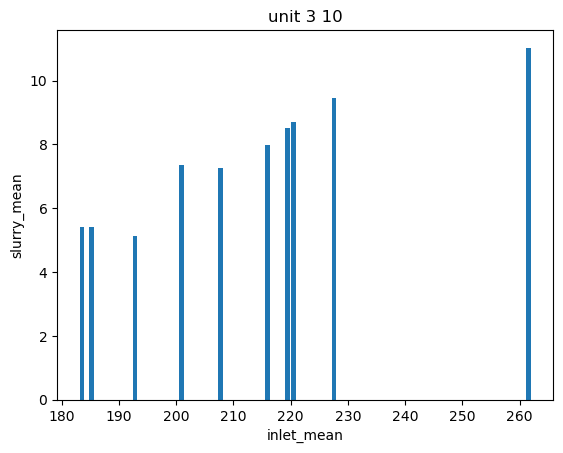

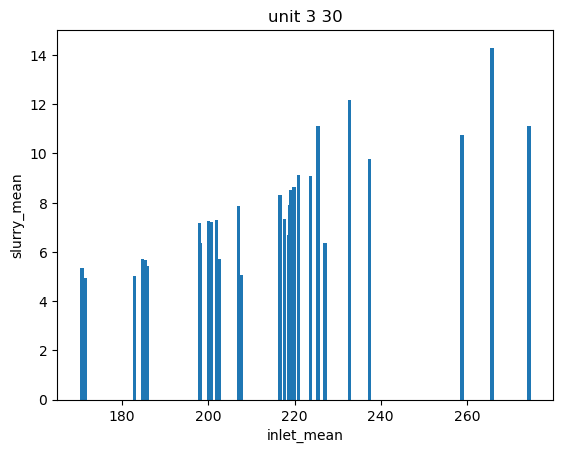

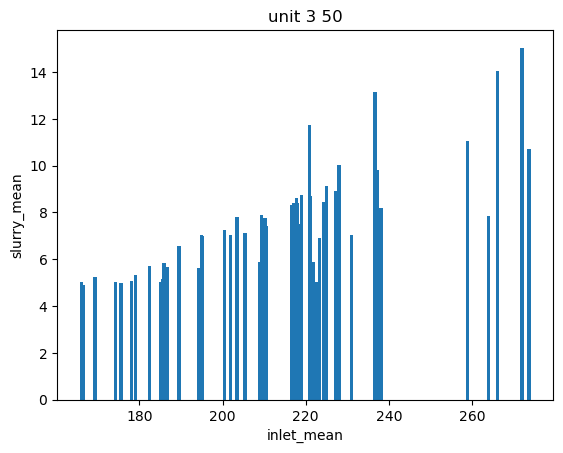

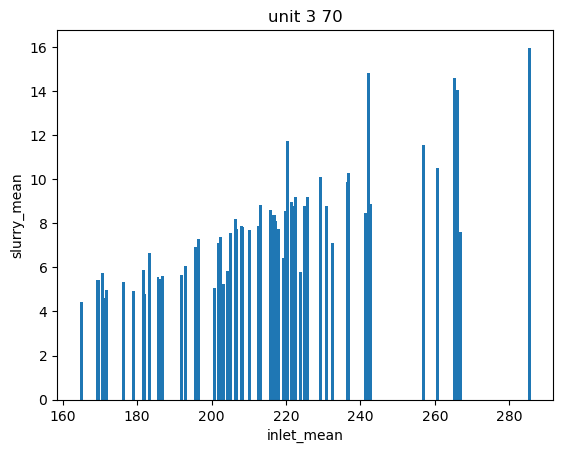

In [29]:
mean3_10 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst3_10):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    mean3_10.at[index, 'ton_mean'] = ton_mean
    mean3_10.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean3_10['inlet_mean'], mean3_10['ton_mean'], label='10')
plt.title('unit 3 10')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean3_30 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst3_30):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    mean3_30.at[index, 'ton_mean'] = ton_mean
    mean3_30.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean3_30['inlet_mean'], mean3_30['ton_mean'], label='10')
plt.title('unit 3 30')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean3_50 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst3_50):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    mean3_50.at[index, 'ton_mean'] = ton_mean
    mean3_50.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean3_50['inlet_mean'], mean3_50['ton_mean'], label='10')
plt.title('unit 3 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean3_70 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst3_70):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    mean3_70.at[index, 'ton_mean'] = ton_mean
    mean3_70.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean3_70['inlet_mean'], mean3_70['ton_mean'], label='10')
plt.title('unit 3 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()

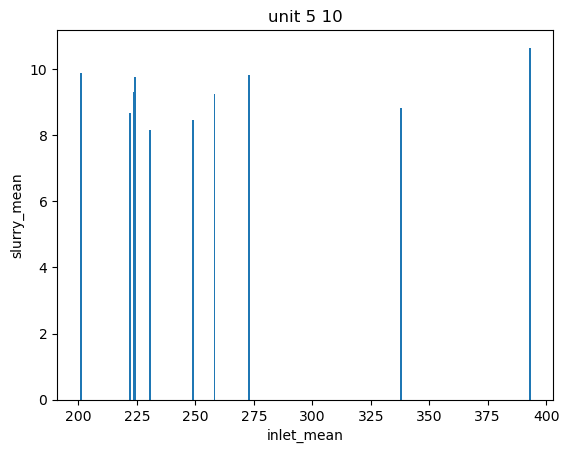

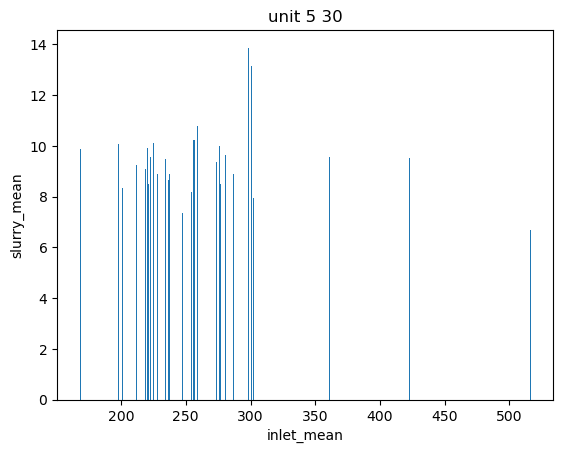

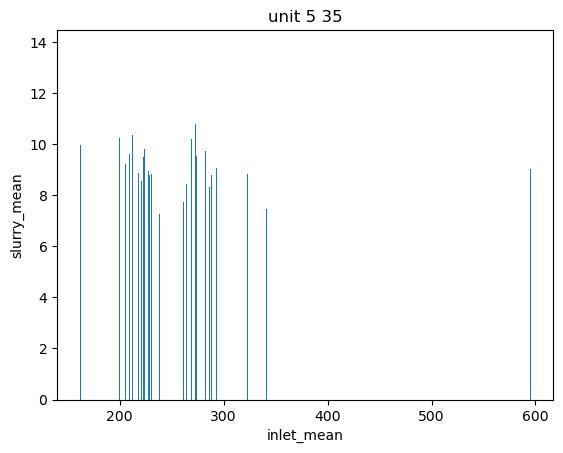

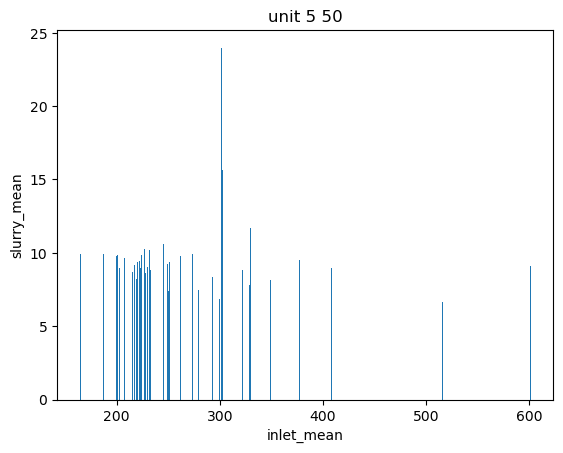

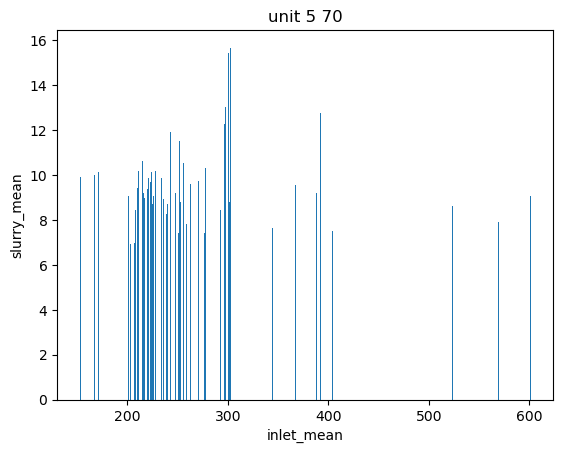

In [30]:
mean5_10 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst5_10):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    mean5_10.at[index, 'ton_mean'] = ton_mean
    mean5_10.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean5_10['inlet_mean'], mean5_10['ton_mean'], label='10')
plt.title('unit 5 10')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean5_30 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst5_30):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    mean5_30.at[index, 'ton_mean'] = ton_mean
    mean5_30.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean5_30['inlet_mean'], mean5_30['ton_mean'], label='10')
plt.title('unit 5 30')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean5_35 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst5_35):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    mean5_35.at[index, 'ton_mean'] = ton_mean
    mean5_35.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean5_35['inlet_mean'], mean5_35['ton_mean'], label='10')
plt.title('unit 5 35')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean5_50 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst5_50):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    mean5_50.at[index, 'ton_mean'] = ton_mean
    mean5_50.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean5_50['inlet_mean'], mean5_50['ton_mean'], label='10')
plt.title('unit 5 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()

########################################################################
mean5_70 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst5_70):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    mean5_70.at[index, 'ton_mean'] = ton_mean
    mean5_70.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean5_70['inlet_mean'], mean5_70['ton_mean'], label='10')
plt.title('unit 5 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()

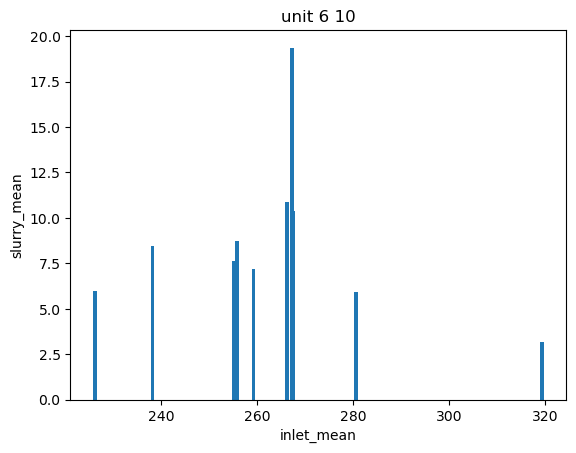

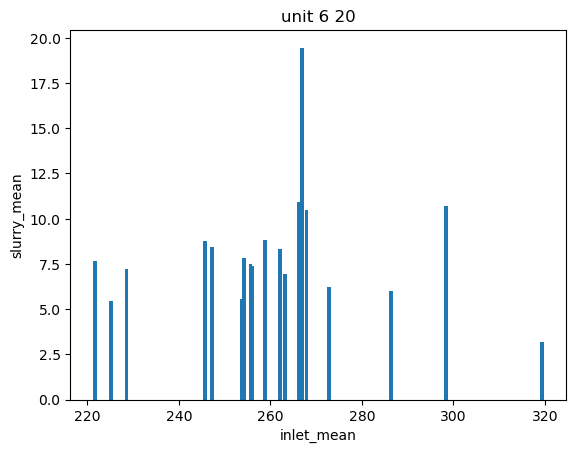

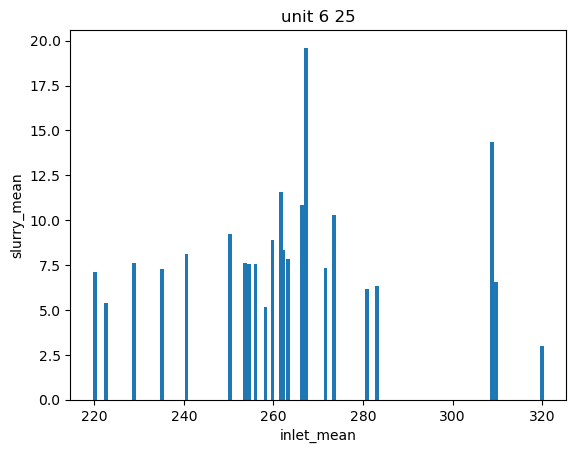

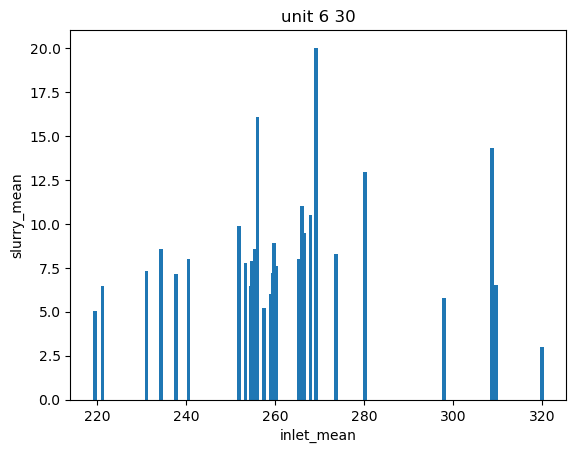

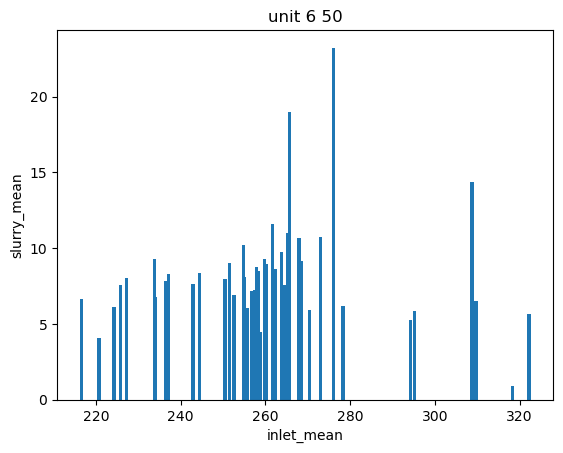

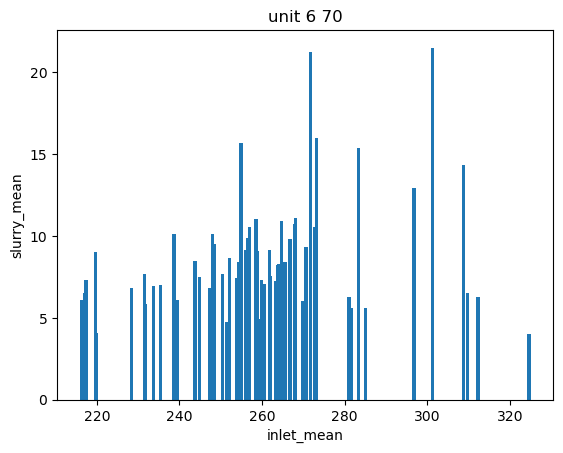

In [31]:
mean6_10 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_10):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_10.at[index, 'ton_mean'] = ton_mean
    mean6_10.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_10['inlet_mean'], mean6_10['ton_mean'], label='10')
plt.title('unit 6 10')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_20 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_20):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_20.at[index, 'ton_mean'] = ton_mean
    mean6_20.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_20['inlet_mean'], mean6_20['ton_mean'], label='10')
plt.title('unit 6 20')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_25 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_25):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_25.at[index, 'ton_mean'] = ton_mean
    mean6_25.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_25['inlet_mean'], mean6_25['ton_mean'], label='10')
plt.title('unit 6 25')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_30 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_30):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_30.at[index, 'ton_mean'] = ton_mean
    mean6_30.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_30['inlet_mean'], mean6_30['ton_mean'], label='10')
plt.title('unit 6 30')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_50 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_50):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_50.at[index, 'ton_mean'] = ton_mean
    mean6_50.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_50['inlet_mean'], mean6_50['ton_mean'], label='10')
plt.title('unit 6 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_70 = pd.DataFrame(columns=['ton_mean','inlet_mean'])

for index, value in enumerate(lst6_70):
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    mean6_70.at[index, 'ton_mean'] = ton_mean
    mean6_70.at[index, 'inlet_mean'] = inlet_mean

plt.bar(mean6_70['inlet_mean'], mean6_70['ton_mean'], label='10')
plt.title('unit 6 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_mean')
plt.show()

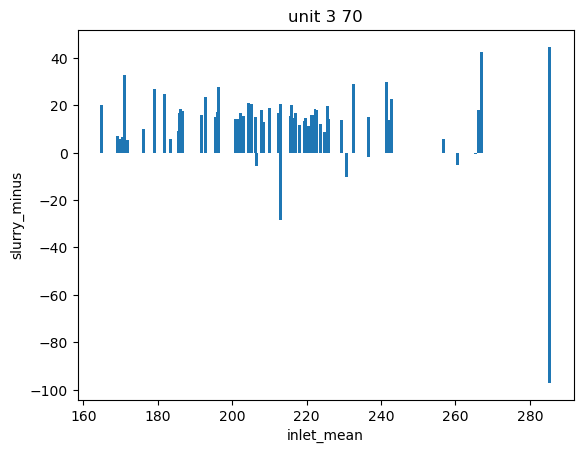

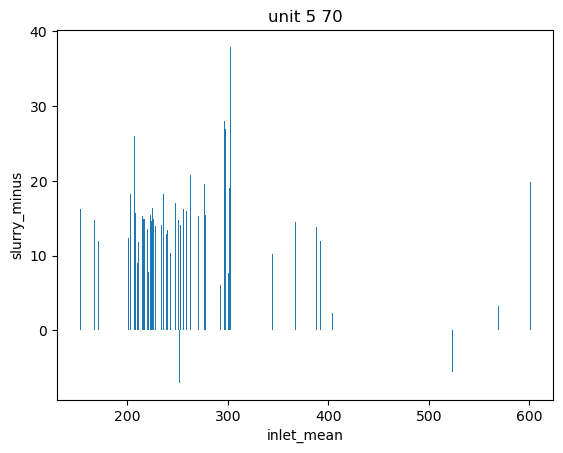

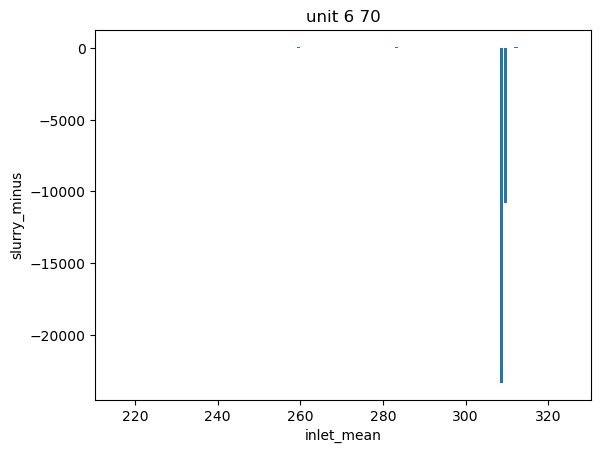

In [32]:
minus3_70 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst3_70):
    length_val = len(value)
    ton_sum = value['ton_3'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    minus3_70.at[index, 'ton_sum'] = ton_sum
    minus3_70.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus3_70.at[index, 'inlet_mean'] = inlet_mean
    minus3_70.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus3_70.at[index, 'count'] = length_val
    minus3_70.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100

plt.bar(minus3_70['inlet_mean'], minus3_70['per'], label='10')
plt.title('unit 3 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus5_70 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst5_70):  
    length_val = len(value)
    ton_sum = value['ton_5'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    minus5_70.at[index, 'ton_sum'] = ton_sum
    minus5_70.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus5_70.at[index, 'inlet_mean'] = inlet_mean
    minus5_70.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus5_70.at[index, 'count'] = length_val
    minus5_70.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100
    
plt.bar(minus5_70['inlet_mean'], minus5_70['per'], label='10')
plt.title('unit 5 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus6_70 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst6_70):
    length_val = len(value)
    ton_sum = value['ton_6'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    minus6_70.at[index, 'ton_sum'] = ton_sum
    minus6_70.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus6_70.at[index, 'inlet_mean'] = inlet_mean
    minus6_70.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus6_70.at[index, 'count'] = length_val
    minus6_70.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100
    
plt.bar(minus6_70['inlet_mean'], minus6_70['per'], label='10')
plt.title('unit 6 70')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()

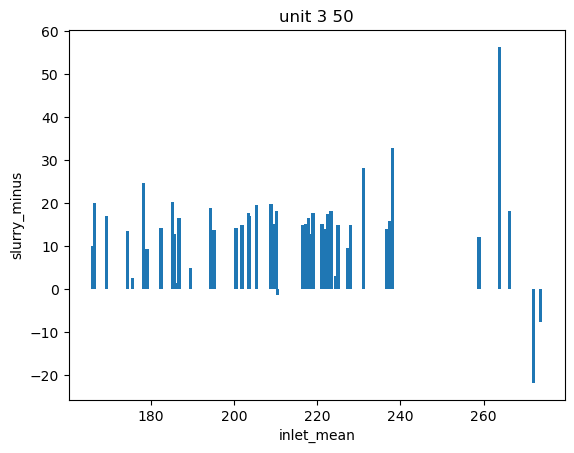

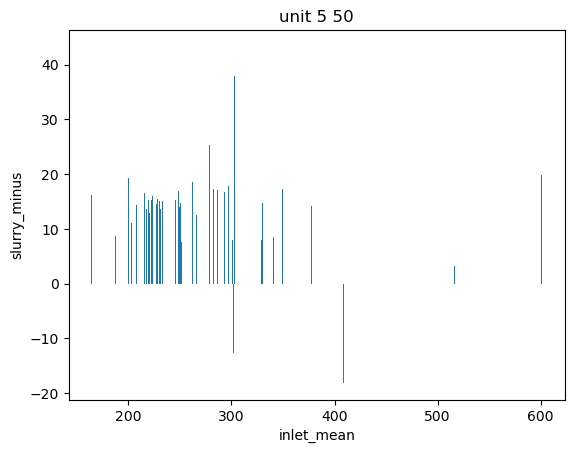

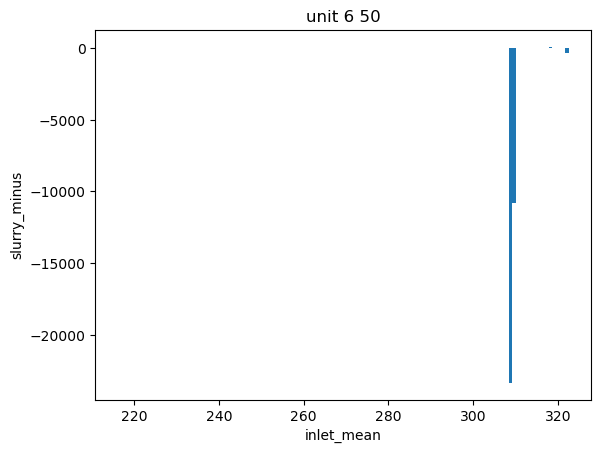

In [33]:
minus3_50 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst3_50):
    length_val = len(value)
    ton_sum = value['ton_3'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    minus3_50.at[index, 'ton_sum'] = ton_sum
    minus3_50.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus3_50.at[index, 'inlet_mean'] = inlet_mean
    minus3_50.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus3_50.at[index, 'count'] = length_val
    minus3_50.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus3_50['inlet_mean'], minus3_50['per'], label='10')
plt.title('unit 3 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus5_50 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst5_50):
    length_val = len(value)
    ton_sum = value['ton_5'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    minus5_50.at[index, 'ton_sum'] = ton_sum
    minus5_50.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus5_50.at[index, 'inlet_mean'] = inlet_mean
    minus5_50.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus5_50.at[index, 'count'] = length_val
    minus5_50.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus5_50['inlet_mean'], minus5_50['per'], label='10')
plt.title('unit 5 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus6_50 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst6_50):
    length_val = len(value)
    ton_sum = value['ton_6'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    minus6_50.at[index, 'ton_sum'] = ton_sum
    minus6_50.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus6_50.at[index, 'inlet_mean'] = inlet_mean
    minus6_50.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus6_50.at[index, 'count'] = length_val
    minus6_50.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100

    
plt.bar(minus6_50['inlet_mean'], minus6_50['per'], label='10')
plt.title('unit 6 50')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()

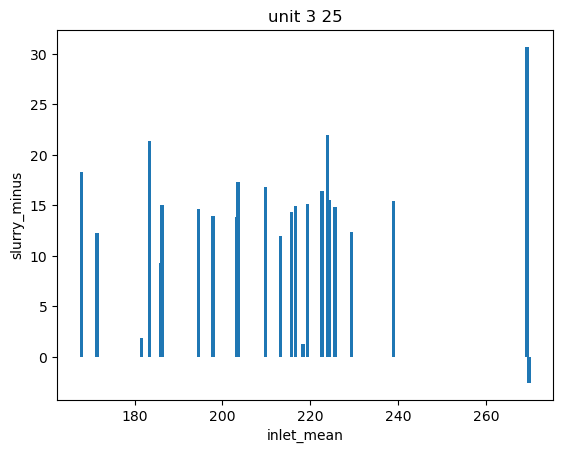

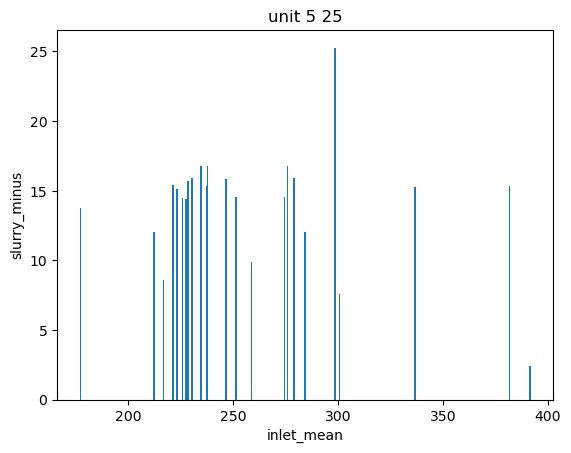

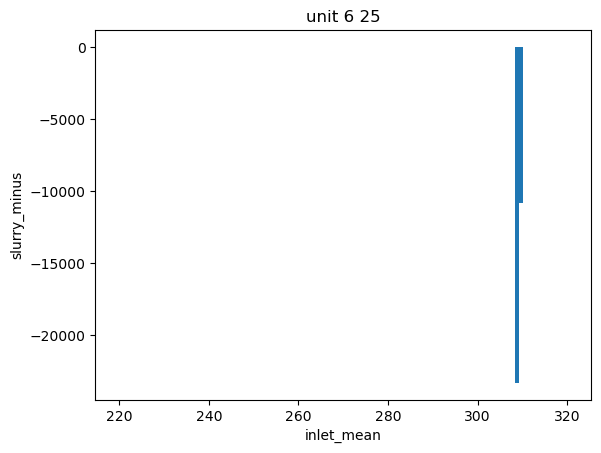

In [35]:
minus3_25 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst3_25):
    length_val = len(value)
    ton_sum = value['ton_3'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    minus3_25.at[index, 'ton_sum'] = ton_sum
    minus3_25.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus3_25.at[index, 'inlet_mean'] = inlet_mean
    minus3_25.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus3_25.at[index, 'count'] = length_val
    minus3_25.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus3_25['inlet_mean'], minus3_25['per'], label='10')
plt.title('unit 3 25')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus5_25 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst5_25):
    length_val = len(value)
    ton_sum = value['ton_5'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    minus5_25.at[index, 'ton_sum'] = ton_sum
    minus5_25.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus5_25.at[index, 'inlet_mean'] = inlet_mean
    minus5_25.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus5_25.at[index, 'count'] = length_val
    minus5_25.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus5_25['inlet_mean'], minus5_25['per'], label='10')
plt.title('unit 5 25')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus6_25 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst6_25):
    length_val = len(value)
    ton_sum = value['ton_6'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    minus6_25.at[index, 'ton_sum'] = ton_sum
    minus6_25.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus6_25.at[index, 'inlet_mean'] = inlet_mean
    minus6_25.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus6_25.at[index, 'count'] = length_val
    minus6_25.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100

    
plt.bar(minus6_25['inlet_mean'], minus6_25['per'], label='10')
plt.title('unit 6 25')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()

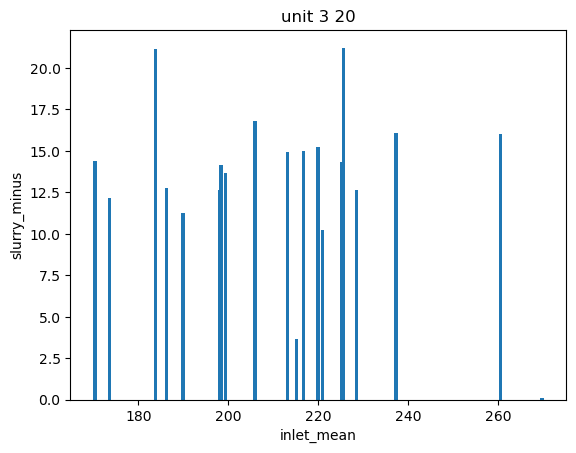

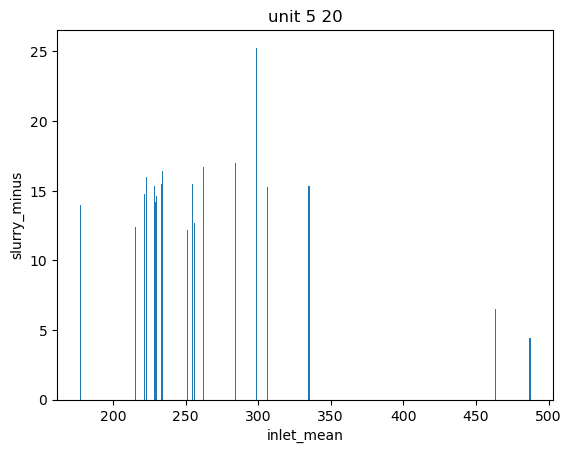

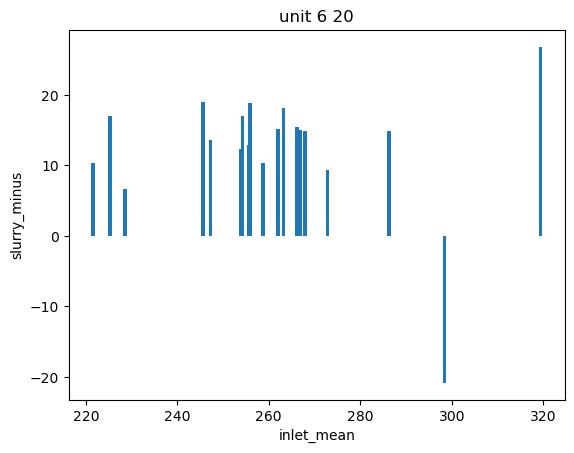

In [36]:
minus3_20 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst3_20):
    length_val = len(value)
    ton_sum = value['ton_3'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_3'].mean()
    
    minus3_20.at[index, 'ton_sum'] = ton_sum
    minus3_20.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus3_20.at[index, 'inlet_mean'] = inlet_mean
    minus3_20.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus3_20.at[index, 'count'] = length_val
    minus3_20.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus3_20['inlet_mean'], minus3_20['per'], label='10')
plt.title('unit 3 20')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus5_20 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst5_20):
    length_val = len(value)
    ton_sum = value['ton_5'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_5'].mean()
    
    minus5_20.at[index, 'ton_sum'] = ton_sum
    minus5_20.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus5_20.at[index, 'inlet_mean'] = inlet_mean
    minus5_20.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus5_20.at[index, 'count'] = length_val
    minus5_20.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus5_20['inlet_mean'], minus5_20['per'], label='10')
plt.title('unit 5 20')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()
########################################################################
minus6_20 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst6_20):
    length_val = len(value)
    ton_sum = value['ton_6'].sum()
    ton_mean = value['ton_10min'].mean()
    inlet_mean = value['inlet_6'].mean()
    
    minus6_20.at[index, 'ton_sum'] = ton_sum
    minus6_20.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus6_20.at[index, 'inlet_mean'] = inlet_mean
    minus6_20.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus6_20.at[index, 'count'] = length_val
    minus6_20.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100

    
plt.bar(minus6_20['inlet_mean'], minus6_20['per'], label='10')
plt.title('unit 6 20')
plt.xlabel('inlet_mean')
plt.ylabel('slurry_minus')
plt.show()

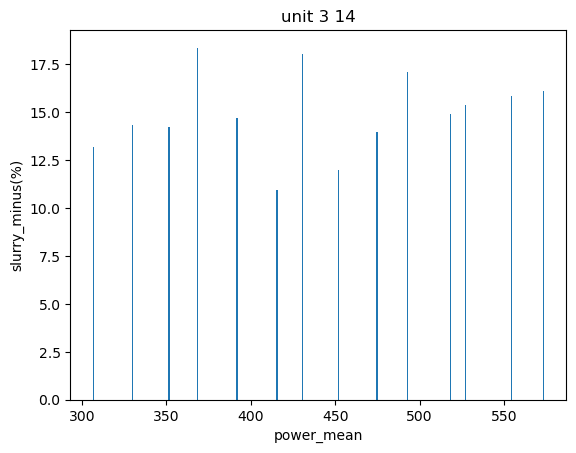

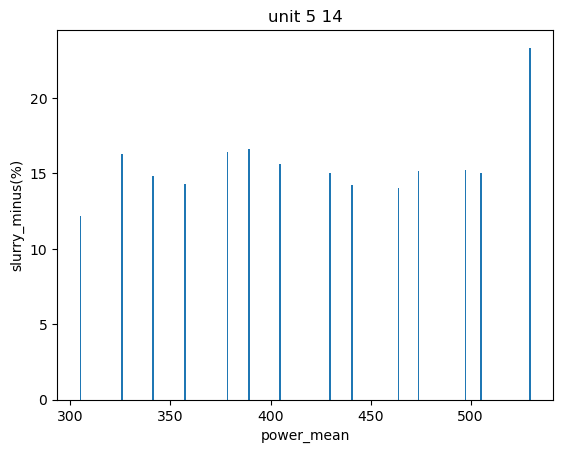

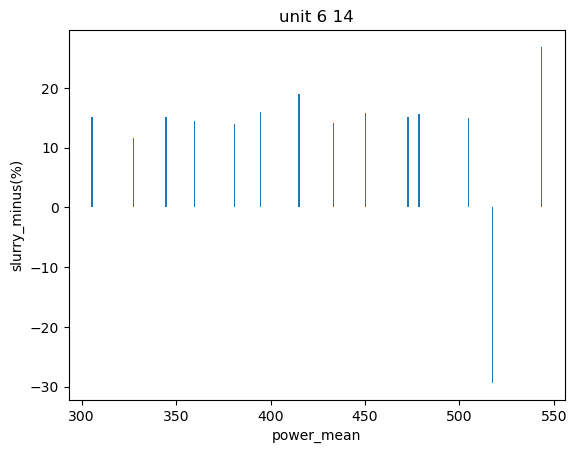

In [37]:
minus3_14 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst3_14):
    length_val = len(value)
    ton_sum = value['ton_3'].sum()
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_3'].mean()
    
    minus3_14.at[index, 'ton_sum'] = ton_sum
    minus3_14.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus3_14.at[index, 'power_mean'] = power_mean
    minus3_14.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus3_14.at[index, 'count'] = length_val
    minus3_14.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus3_14['power_mean'], minus3_14['per'], label='10')
plt.title('unit 3 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_minus(%)')
plt.show()
########################################################################
minus5_14 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst5_14):
    length_val = len(value)
    ton_sum = value['ton_5'].sum()
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_5'].mean()
    
    minus5_14.at[index, 'ton_sum'] = ton_sum
    minus5_14.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus5_14.at[index, 'power_mean'] = power_mean
    minus5_14.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus5_14.at[index, 'count'] = length_val
    minus5_14.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100


plt.bar(minus5_14['power_mean'], minus5_14['per'], label='10')
plt.title('unit 5 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_minus(%)')
plt.show()
########################################################################
minus6_14 = pd.DataFrame(columns=['ton_sum','ton_mean-15','inlet_mean','minus','count'])

for index, value in enumerate(lst6_14):
    length_val = len(value)
    ton_sum = value['ton_6'].sum()
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_6'].mean()
    
    minus6_14.at[index, 'ton_sum'] = ton_sum
    minus6_14.at[index, 'ton_mean-15'] = (ton_mean - ton_mean*0.15)*length_val
    minus6_14.at[index, 'power_mean'] = power_mean
    minus6_14.at[index, 'minus'] = ton_sum - (ton_mean - ton_mean*0.15)*length_val
    minus6_14.at[index, 'count'] = length_val
    minus6_14.at[index, 'per'] = ((ton_sum - (ton_mean - ton_mean*0.15)*length_val)/ton_sum)*100

    
plt.bar(minus6_14['power_mean'], minus6_14['per'], label='10')
plt.title('unit 6 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_minus(%)')
plt.show()

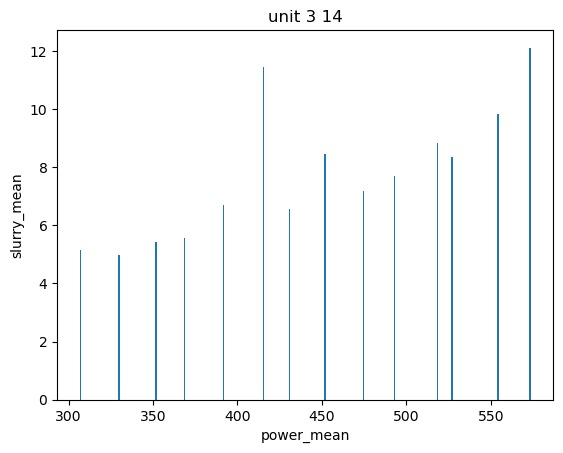

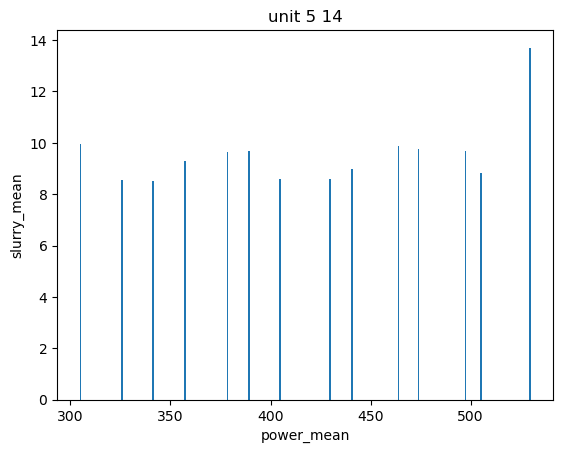

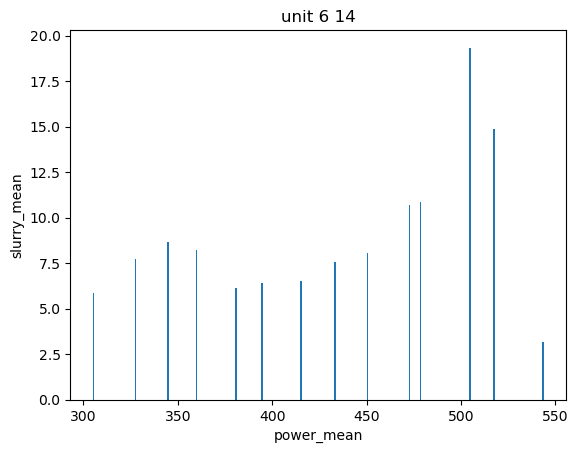

In [40]:
mean3_14 = pd.DataFrame(columns=['ton_mean','power_mean'])

for index, value in enumerate(lst3_14):
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_3'].mean()
    
    mean3_14.at[index, 'ton_mean'] = ton_mean
    mean3_14.at[index, 'power_mean'] = power_mean

plt.bar(mean3_14['power_mean'], mean3_14['ton_mean'], label='10')
plt.title('unit 3 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean5_14 = pd.DataFrame(columns=['ton_mean','power_mean'])

for index, value in enumerate(lst5_14):
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_5'].mean()
    
    mean5_14.at[index, 'ton_mean'] = ton_mean
    mean5_14.at[index, 'power_mean'] = power_mean

plt.bar(mean5_14['power_mean'], mean5_14['ton_mean'], label='10')
plt.title('unit 5 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_mean')
plt.show()
########################################################################
mean6_14 = pd.DataFrame(columns=['ton_mean','power_mean'])

for index, value in enumerate(lst6_14):
    ton_mean = value['ton_10min'].mean()
    power_mean = value['power_6'].mean()
    
    mean6_14.at[index, 'ton_mean'] = ton_mean
    mean6_14.at[index, 'power_mean'] = power_mean

plt.bar(mean6_14['power_mean'], mean6_14['ton_mean'], label='10')
plt.title('unit 6 14')
plt.xlabel('power_mean')
plt.ylabel('slurry_mean')
plt.show()

In [41]:
lst3_14[0]

,date,power_3,outlet_3,inlet_3,ton_3,normal_3,date_10min,power_10min,outlet_10min,inlet_10min,ton_10min,normal_10min,power_bins10,power_bins14,power_bins20,power_bins25,power_bins30,power_bins50,power_bins70
141,2023-09-01 11:45:00,307.0,1.64,179.890000,4.990000,정상,2023-09-01 11:55,308.0,1.28,172.820000,1.320000,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(299.0, 308.53333333333336]","(304.72, 310.44]","(303.0857142857143, 307.1714285714286]"
142,2023-09-01 11:50:00,310.0,1.17,175.610000,3.260000,정상,2023-09-01 12:00,310.0,1.12,173.480000,0.730000,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(308.53333333333336, 318.06666666666666]","(304.72, 310.44]","(307.1714285714286, 311.25714285714287]"
143,2023-09-01 11:55:00,308.0,1.28,172.820000,1.320000,정상,2023-09-01 12:05,306.0,1.38,171.560000,39.940000,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(299.0, 308.53333333333336]","(304.72, 310.44]","(307.1714285714286, 311.25714285714287]"
144,2023-09-01 12:00:00,310.0,1.12,173.480000,0.730000,정상,2023-09-01 12:10,309.0,1.32,171.790000,43.830000,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(308.53333333333336, 318.06666666666666]","(304.72, 310.44]","(307.1714285714286, 311.25714285714287]"
145,2023-09-01 12:05:00,306.0,1.38,171.560000,39.940000,정상,2023-09-01 12:15,316.0,0.42,168.410000,42.300000,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(299.0, 308.53333333333336]","(304.72, 310.44]","(303.0857142857143, 307.1714285714286]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48556,2024-02-13 14:20:00,303.0,3.30,225.708750,4.015885,정상,2024-02-13 14:30,319.0,3.18,241.614848,3.638070,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(299.0, 308.53333333333336]","(299.0, 304.72]","(299.0, 303.0857142857143]"
48557,2024-02-13 14:25:00,301.0,3.40,237.621429,4.054933,정상,2024-02-13 14:35,338.0,2.88,251.533000,3.237149,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(299.0, 313.3]","(299.0, 310.44]","(299.0, 308.53333333333336]","(299.0, 304.72]","(299.0, 303.0857142857143]"
48558,2024-02-13 14:30:00,319.0,3.18,241.614848,3.638070,정상,2024-02-13 14:40,349.0,3.34,256.610278,3.109927,정상,"(299.0, 327.6]","(299.0, 319.42857142857144]","(313.3, 327.6]","(310.44, 321.88]","(318.06666666666666, 327.6]","(316.16, 321.88]","(315.34285714285716, 319.42857142857144]"
49692,2024-02-17 13:00:00,317.0,3.10,165.626875,4.612068,정상,2024-02-17 13:10,353.0,3.01,181.160000,4.773654,교정중,"(299.0, 327.6]","(299.0, 319.42857142857144]","(313.3, 327.6]","(310.44, 321.88]","(308.53333333333336, 318.06666666666666]","(316.16, 321.88]","(315.34285714285716, 319.42857142857144]"


In [44]:
count3_25 = minus3_25['count']
count5_25 = minus5_25['count']
count6_25 = minus6_25['count']

count_25 = pd.DataFrame({
    'unit3_count': count3_25,
    'unit5_count': count5_25,
    'unit6_count': count6_25
})

count_25

count_25.to_csv('unit_count25.csv', index=False)

In [46]:
minus6_14

,ton_sum,ton_mean-15,inlet_mean,minus,count,power_mean,per
0,1836.588701,1559.438285,NaN,277.150416,312,305.500000,15.090500
1,1676.526491,1482.614191,NaN,193.912299,225,327.515556,11.566313
2,7457.277919,6334.861631,NaN,1122.416288,858,344.731935,15.051287
3,2065.221485,1766.622009,NaN,298.599475,253,359.833992,14.458472
4,4831.216242,4158.32367,NaN,672.892572,798,380.894737,13.928016
5,1169.574153,982.186444,NaN,187.387708,180,394.672222,16.021875
6,725.187624,588.021334,NaN,137.16629,106,415.198113,18.914593
7,22689.965566,19471.483788,NaN,3218.481778,3035,433.229325,14.184604
8,7403.344621,6233.576027,NaN,1169.768594,911,450.365532,15.800542
9,241022.92982,204761.037583,NaN,36261.892237,22539,472.799193,15.044997


In [49]:
count3_14 = minus3_14['count']
count5_14 = minus5_14['count']
count6_14 = minus6_14['count']

count_14 = pd.DataFrame({
    'unit3_count': count3_14,
    'unit5_count': count5_14,
    'unit6_count': count6_14
})

count_14

count_14.to_csv('unit_count14.csv', index=False)

In [50]:
print('3호기 평균 저감 비율:',minus3_14.per.mean())
print('5호기 평균 저감 비율:',minus5_14.per.mean())
print('6호기 평균 저감 비율:',minus6_14.per.mean())

3호기 평균 저감 비율: 14.93470808921444
5호기 평균 저감 비율: 15.594105495546922
6호기 평균 저감 비율: 12.727319035231316


In [52]:
tot = minus3_14.per.mean()+minus5_14.per.mean()+minus6_14.per.mean()
print(tot/3)

14.418710873330893


In [59]:
mean6_14

,ton_mean,power_mean
0,5.880235,305.5
1,7.752231,327.515556
2,8.686222,344.731935
3,8.214936,359.833992
4,6.130508,380.894737
5,6.419519,394.672222
6,6.526319,415.198113
7,7.547818,433.229325
8,8.050076,450.365532
9,10.687934,472.799193
